In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
from iminuit import Minuit
from iminuit.cost import LeastSquares
import pickle
import uproot as ur
import re

In [15]:
with open("../../genIII_data/JLab/Ptrg/Ptrg1.pkl", 'rb') as file:
    ped = pickle.load(file)
with open("../../genIII_data/JLab/Cosmic/Cosmic_MIPs.pkl", 'rb') as file:
    mip = pickle.load(file)
with open("../../genIII_data/JLab/Beam/Beam1-HGLG.pkl", 'rb') as file:
    ratio = pickle.load(file)
with open("geometry.pkl", 'rb') as file:
    geometry = pickle.load(file)

In [16]:
input_file = f"../../genIII_data/JLab/Beam/Beam1_0.root"

events = ur.open("%s:raw"%(input_file))

In [17]:
print(len(np.array(events['ch_0'])))

91324


In [18]:
beam = {}

for ch_key in events.keys():
    match = re.match(r"ch_(\d+)", ch_key)
    if not match:
        continue

    ID = int(match.group(1))
    values = np.array(events[ch_key])  # (n_events, 2) — each row is (LG, HG)

    # Initialize lists
    if f"{ID}_LG" not in beam:
        beam[f"{ID}_LG"] = []
        beam[f"{ID}_HG"] = []

    for i, (LG, HG) in enumerate(values):
        beam[f"{ID}_LG"].append(float(LG))
        beam[f"{ID}_HG"].append(float(HG))

Text(0, 0.5, 'Count')

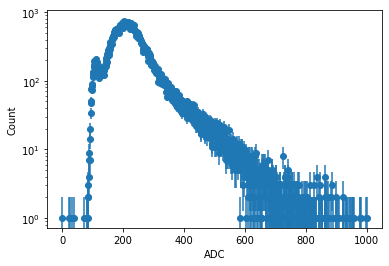

In [19]:
data = np.array(beam["12_LG"])
counts, bin_edges = np.histogram(data, bins=1000, range=[0, 1000])
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
errors = np.sqrt(counts)
plt.errorbar(bin_centers, counts, yerr=errors, fmt='o')
plt.yscale('log')
plt.xlabel("ADC")
plt.ylabel("Count")


In [20]:
num_channels = 64 * 6
num_events = len(next(iter(beam.values())))

# Compute the true channel number
geometry["true_channel"] = geometry["caen"] * 64 + geometry["caen_channel"]

# Set index to true_channel for quick lookup
df_positions = geometry.set_index("true_channel")

# Precompute valid channels that exist in both beam and geometry
valid_channels = [
    ch for ch in range(num_channels)
    if f"{ch}_LG" in beam and ch in df_positions.index
]
valid_channels = np.array(valid_channels)

# Precompute all static values for valid channels
x_vals = np.array([df_positions.loc[ch]['x'] for ch in valid_channels])
y_vals = np.array([df_positions.loc[ch]['y'] for ch in valid_channels])
z_vals = np.array([df_positions.loc[ch]['z'] for ch in valid_channels])
layers = np.array([df_positions.loc[ch]['layer'] for ch in valid_channels])
chs = np.array([df_positions.loc[ch]['brd_channel'] for ch in valid_channels])
ped_means = np.array([ped['LGPedMean'][ch] for ch in valid_channels])
ped_sigmas = np.array([ped['LGPedSigma'][ch] for ch in valid_channels])
ratios = np.array([ratio[ch] for ch in valid_channels])
mips = np.array([mip[ch] for ch in valid_channels])

# Stack x, y, z into one array
positions = np.stack([x_vals, y_vals, z_vals, layers, chs], axis=1)

beam_lg_mips = []

# User-configurable settings
range1 = np.arange(0, 24)    # First channel range
range2 = np.arange(25, 49)   # Second channel range
required_hits_range1 = 1     # Required hits in range 0–23
threshold = 0.3             # MIP threshold

for evt in range(num_events):
    if evt % 10000 == 0:
        print(100 * evt / num_events)

    raw_vals = np.array([beam[f"{ch}_LG"][evt] for ch in valid_channels])
    val_subtracted = raw_vals - ped_means

    # Compute mask for valid hits
    valid_mask = (
        (val_subtracted >= threshold * ped_sigmas) &
        (ratios != 0) &
        (mips != 0)
    )

    # Compute MIPs where valid, else 0
    mips_vals = np.zeros_like(val_subtracted)
    mips_vals[valid_mask] = (val_subtracted[valid_mask] * ratios[valid_mask]) / mips[valid_mask]

    # Get indices for each channel range in the valid_channels array
    idx_range1 = np.where(np.isin(valid_channels, range1))[0]
    idx_range2 = np.where(np.isin(valid_channels, range2))[0]

    # Count how many channels in each range exceed the threshold
    hits_range1 = np.sum(mips_vals[idx_range1] >= threshold)
    hits_range2 = np.sum(mips_vals[idx_range2] >= threshold)

    # Filter based on the required number of hits in each range
    if hits_range1 == required_hits_range1:
        beam_lg_mips.append(mips_vals)



beam_lg_mips = np.array(beam_lg_mips, dtype=object)


0.0
10.950024090052999
21.900048180105998
32.850072270158996
43.800096360211995
54.750120450264994
65.70014454031799
76.65016863037098
87.60019272042399
98.55021681047698


In [21]:
beam_data = {
    'positions': positions,
    'events': beam_lg_mips
}

In [22]:
with open('../../genIII_data/JLab/Beam/Beam-Cal.pkl', 'wb') as f:
    pickle.dump(beam_data, f)

In [14]:
print(beam_lg_mips[5][25])


0.011738875251652252
